# 2024-02-05 Explore Trained Threshold

**Goal** To visualize training curves in order to inform decisions on creating a "trained" dataset for each animal.

**Note!** these will not run but keeping here to show how plots were made for 02-08 meeting and more detailed analysis of determining hit threshold


Related notebooks
* `eda.ipynb`

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from multiglm.data.dataset_loader import *
from multiglm.data.dataset_thresholder import *

sns.set_context("talk")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial Dev Scraps:


In [ ]:
break

In [25]:
def calculate_threshold_crossings(
    data_frame, column_name, window, threshold, training_stage_threshold=3
):
    # Filter the DataFrame based on window size and training stage
    filtered_df = data_frame.query(
        "window_size == @window and training_stage > @training_stage_threshold"
    ).copy()

    # Calculate threshold crossings
    column_to_check = f"rolling_mean_{column_name}"
    filtered_df["crossed_threshold"] = (
        filtered_df[column_to_check].shift() < threshold
    ) & (filtered_df[column_to_check] >= threshold)

    # Count threshold crossings
    crossings_count = (
        filtered_df.groupby("animal_id")["crossed_threshold"].sum().reset_index()
    )

    # Calculate min, median, and max sessions of crossings
    threshold_df = crossings_count.copy()
    grouped = filtered_df.groupby("animal_id")

    threshold_df["min_cross_sess"] = grouped.apply(
        lambda x: x.loc[x["crossed_threshold"]].session.min()
    ).values
    threshold_df["med_cross_sess"] = grouped.apply(
        lambda x: x.loc[x["crossed_threshold"]].session.median()
    ).values
    threshold_df["max_cross_sess"] = grouped.apply(
        lambda x: x.loc[x["crossed_threshold"]].session.max()
    ).values

    # Assign additional info
    threshold_df["window_size"] = window
    threshold_df["type"] = column_name
    threshold_df.rename(
        columns={"crossed_threshold": "crossed_threshold_count"}, inplace=True
    )

    return threshold_df

## Threshold at hit 70%

In [ ]:
# based on early EDA, only a few animals need the violation threshold
apply_viol_threshold = ["W065", "W080", "W083", "W088"]

hit_viol_threshold_df.loc[
    ~hit_viol_threshold_df["animal_id"].isin(apply_viol_threshold),
    "violation_threshold",
] = None
hit_viol_threshold_df

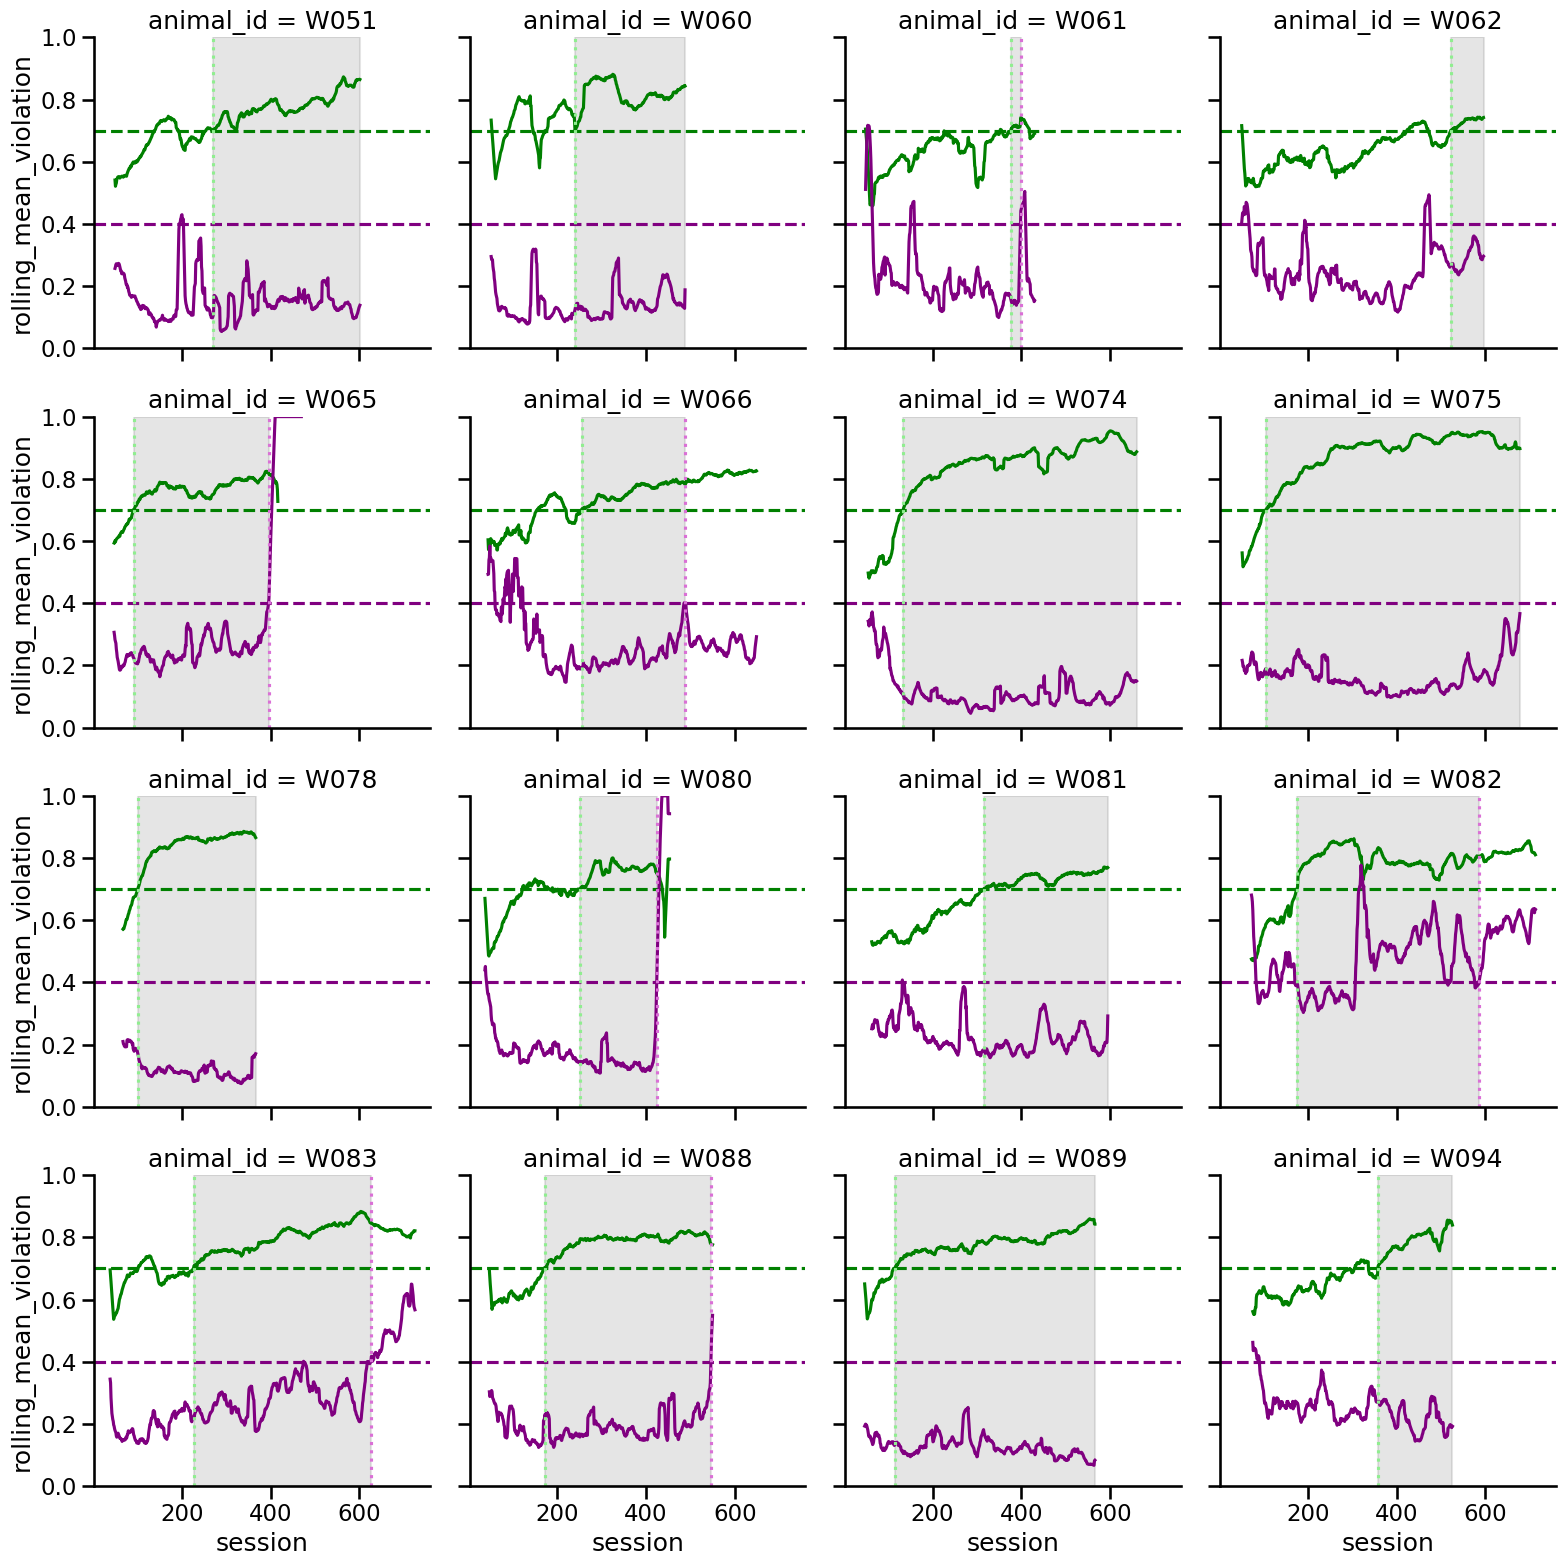

In [ ]:
# plot_data = hit_viol_merge.query("window_size == @hit_window")
plot_data = plot_data
g = sns.FacetGrid(
    data=plot_data,
    col="animal_id",
    col_wrap=4,
    height=4,
    ylim=(0, 1),
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color="green")
g.map(plt.axhline, y=0.70, color="green", linestyle="--")
g.map(sns.lineplot, "session", "rolling_mean_violation", color="purple")
g.map(plt.axhline, y=0.40, color="purple", linestyle="--")

# Assuming hit_viol_threshold_df and g are already defined
for ii, ax in enumerate(g.axes.flat):
    hit_threshold = hit_viol_threshold_df["hit_threshold"][ii]
    violation_threshold = hit_viol_threshold_df["violation_threshold"][ii]
    animal_id = hit_viol_threshold_df["animal_id"][ii]

    # Draw the first axvline for hit_threshold
    ax.axvline(x=hit_threshold, color="lightgreen", linestyle=":")

    if pd.notna(violation_threshold):
        ax.axvline(x=violation_threshold, color="orchid", linestyle=":")
        # Use fill_between to shade the area between the two axvlines
        ax.fill_betweenx(
            ax.get_ylim(), hit_threshold, violation_threshold, color="grey", alpha=0.2
        )
    else:
        # If violation_threshold is None, shade to the end of the line
        # Determine the maximum x-axis value from your data or use a predefined max value
        # print("evaluating!")
        max_x_value = plot_data.query(
            "animal_id == @animal_id"
        ).session.max()  # Or use a specific value based on your dataset
        ax.fill_betweenx(
            ax.get_ylim(), hit_threshold, max_x_value, color="grey", alpha=0.2
        )

In [ ]:
filtered_df = (
    df.query("training_stage > 3")
    .groupby("animal_id")
    .apply(filter_sessions)
    .reset_index(drop=True)
)

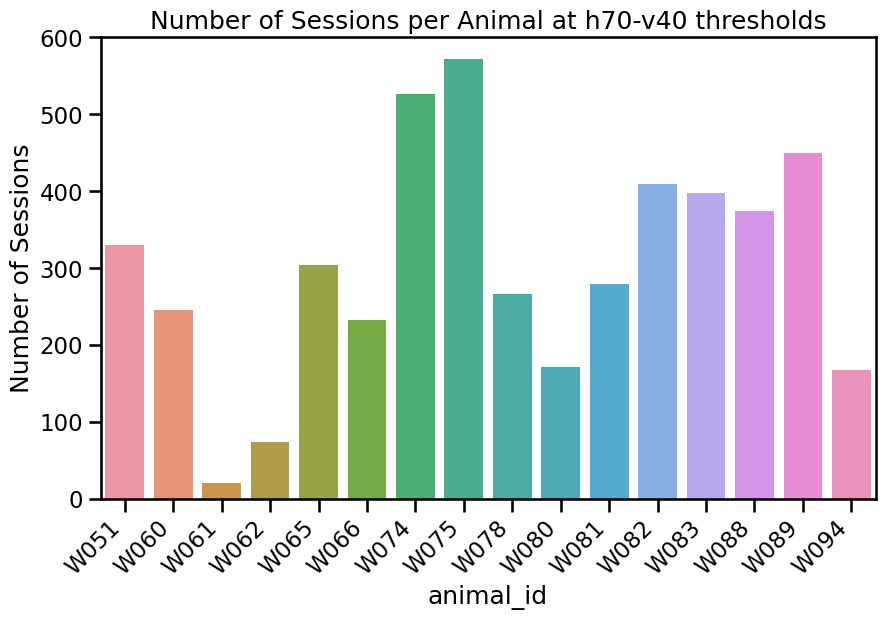

In [ ]:
filtered_summary_stats = (
    filtered_df.groupby("animal_id")
    .agg(n_trials=("hit", "count"), n_sessions=("session", "nunique"))
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x="animal_id", y="n_sessions", data=filtered_summary_stats, ax=ax)


_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

_ = ax.set(
    title="Number of Sessions per Animal at h70-v40 thresholds",
    ylabel="Number of Sessions",
)

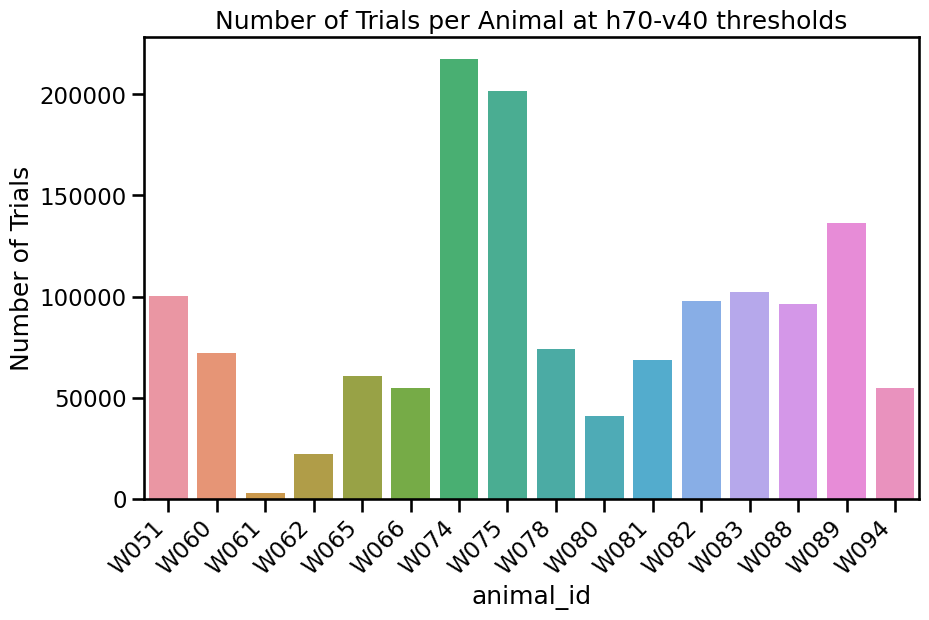

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x="animal_id", y="n_trials", data=filtered_summary_stats, ax=ax)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


_ = ax.set(
    title="Number of Trials per Animal at h70-v40 thresholds",
    ylabel="Number of Trials",
)

## Threshold at hit 73%

In [ ]:
# Generate DataFrames for both hit and violation thresholds
hit_threshold = 0.73
hit_threshold_df = calculate_threshold_crossings(hit_means, "hit", 21, hit_threshold)
viol_threshold_df = calculate_threshold_crossings(viol_means, "violation", 14, 0.40)

# Merge the DataFrames on 'animal_id'
hit_viol_threshold_df = hit_threshold_df[["animal_id", "max_cross_sess"]].merge(
    viol_threshold_df[["animal_id", "max_cross_sess"]],
    on="animal_id",
    suffixes=("_hit", "_viol"),
)

# Rename the columns
hit_viol_threshold_df.rename(
    columns={
        "max_cross_sess_hit": "hit_threshold",
        "max_cross_sess_viol": "violation_threshold",
    },
    inplace=True,
)
hit_viol_threshold_df.loc[
    hit_viol_threshold_df.violation_threshold < hit_viol_threshold_df.hit_threshold,
    "violation_threshold",
] = None

# based on early EDA, only a few animals need the violation threshold
apply_viol_threshold = ["W065", "W080", "W083", "W088"]

hit_viol_threshold_df.loc[
    ~hit_viol_threshold_df["animal_id"].isin(apply_viol_threshold),
    "violation_threshold",
] = None
hit_viol_threshold_df

,animal_id,hit_threshold,violation_threshold
0,W051,327,NaN
1,W060,249,NaN
2,W061,399,NaN
3,W062,553,NaN
4,W065,103,396.0
5,W066,316,NaN
6,W074,145,NaN
7,W075,126,NaN
8,W078,106,NaN
9,W080,272,425.0


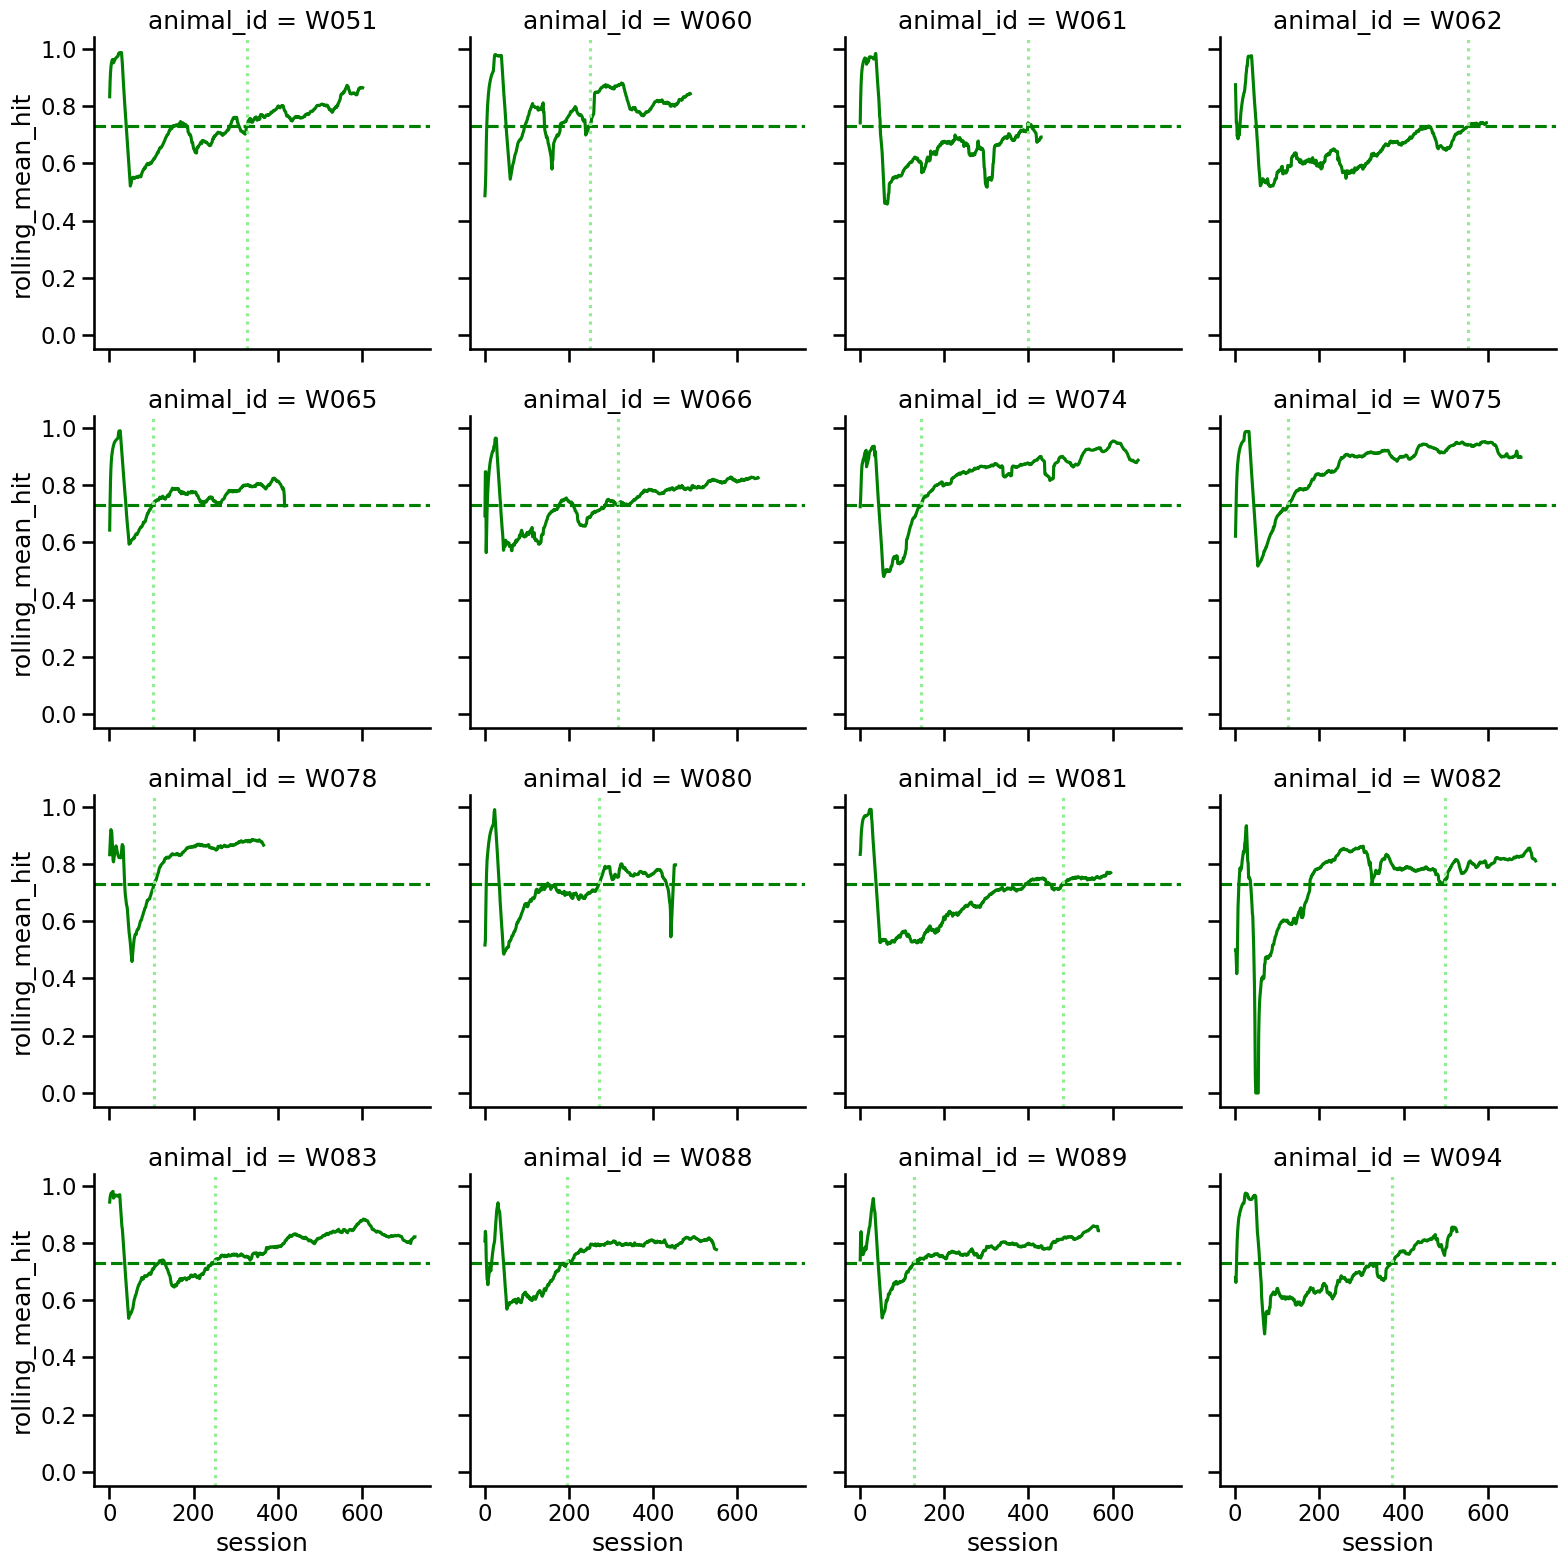

In [ ]:
# # Create the facet grid plot
window_size = hit_threshold_df["window_size"].unique()[0]
g = sns.FacetGrid(
    data=hit_means.query("window_size == @window_size"),
    col="animal_id",
    col_wrap=4,
    height=4,
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color="green")
g.map(plt.axhline, y=hit_threshold, color="green", linestyle="--")


for ii, ax in enumerate(g.axes.flat):
    ax.axvline(
        x=hit_viol_threshold_df["hit_threshold"][ii], color="lightgreen", linestyle=":"
    )

In [ ]:
hit_window = 21
hit_data = hit_viol_merge.query("window_size == @hit_window")[
    ["animal_id", "session", "rolling_mean_hit", "window_size"]
]
viol_window = 14
viol_data = hit_viol_merge.query("window_size == @viol_window")[
    ["animal_id", "session", "rolling_mean_violation", "window_size"]
]
plot_data = pd.merge(
    hit_data, viol_data, on=["animal_id", "session"], suffixes=("_hit", "_viol")
)

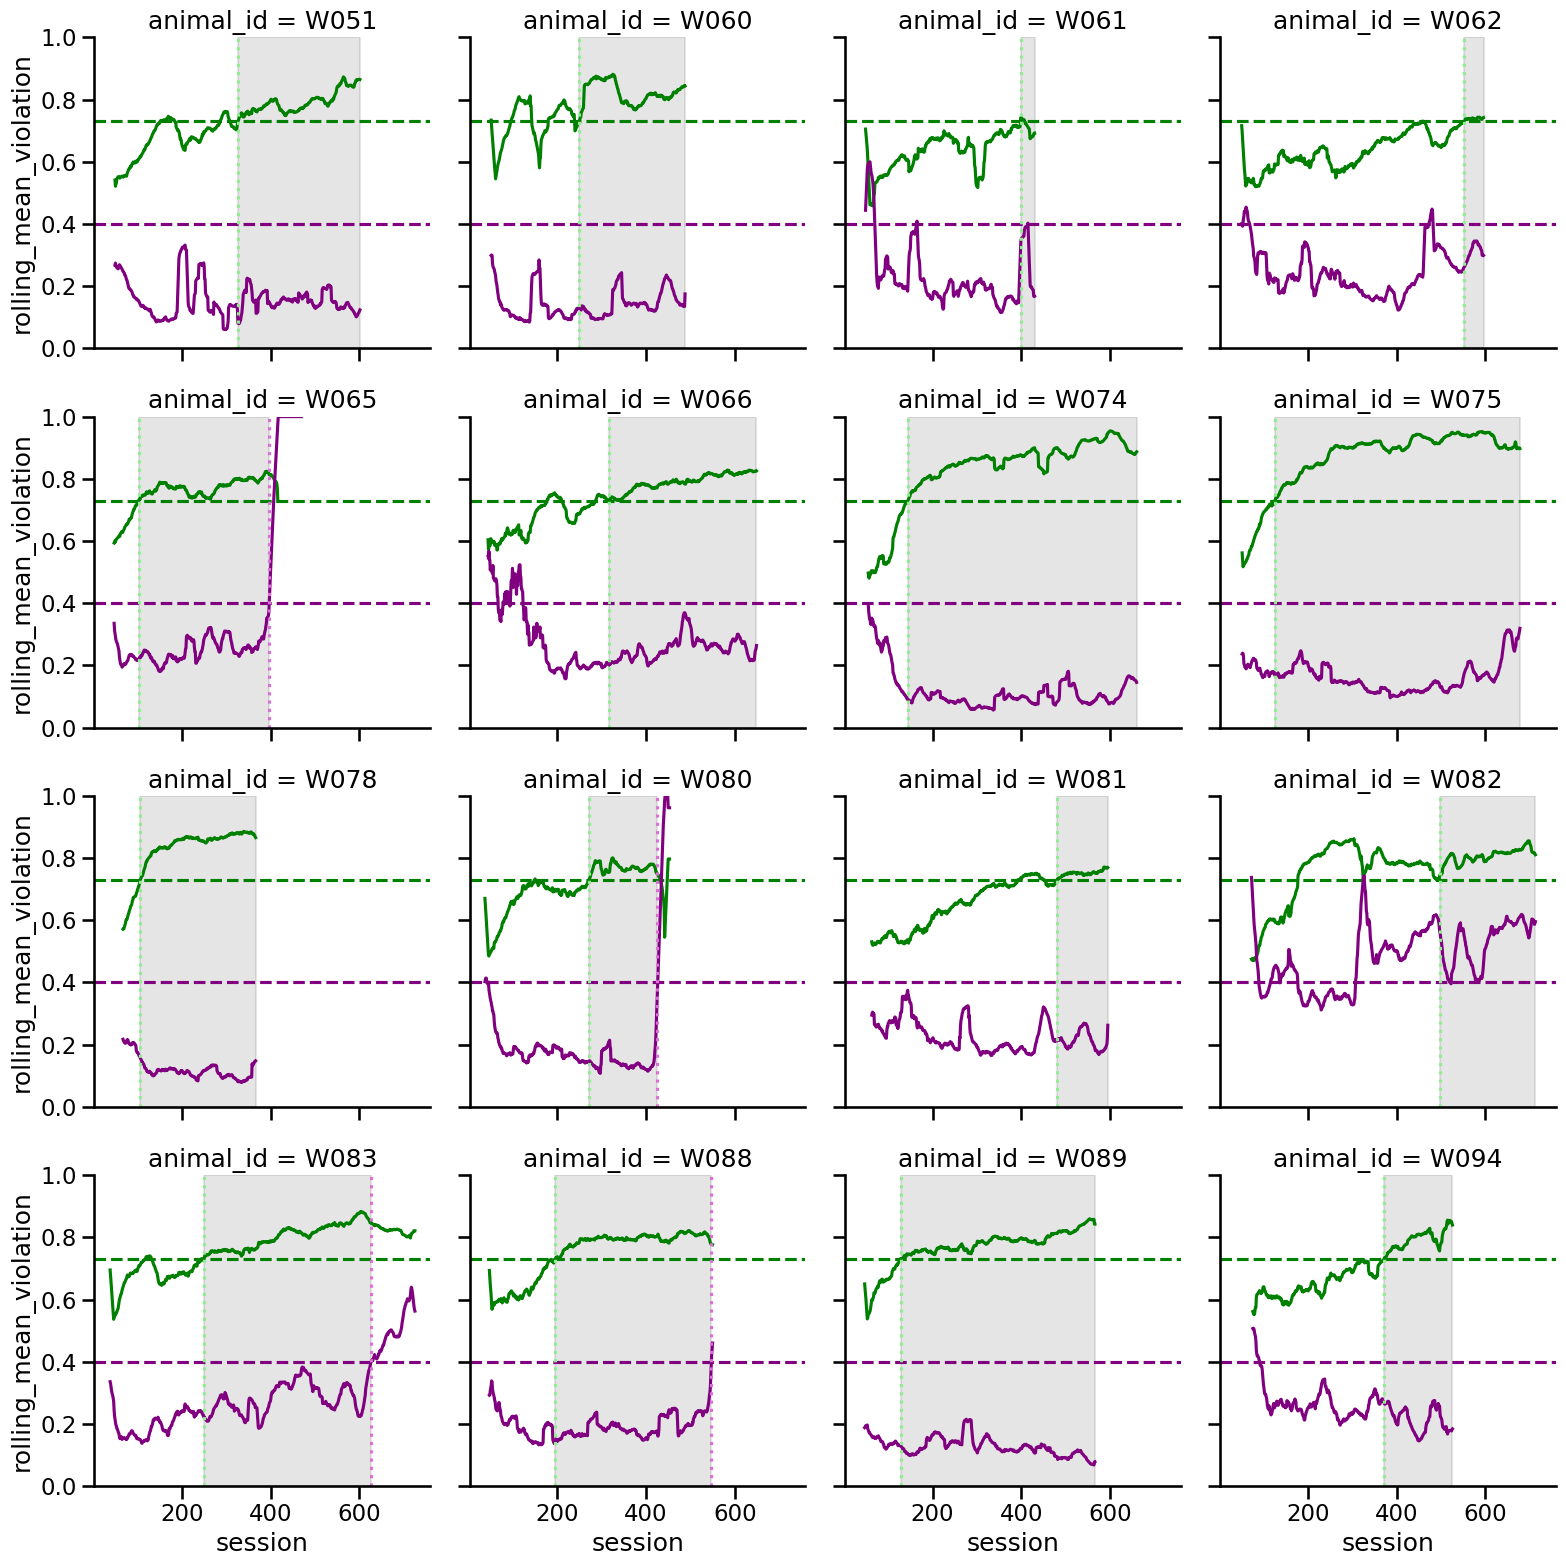

In [ ]:
plot_data = hit_viol_merge.query("window_size == @hit_window")
plot_data = plot_data
g = sns.FacetGrid(
    data=plot_data,
    col="animal_id",
    col_wrap=4,
    height=4,
    ylim=(0, 1),
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color="green")
g.map(plt.axhline, y=hit_threshold, color="green", linestyle="--")
g.map(sns.lineplot, "session", "rolling_mean_violation", color="purple")
g.map(plt.axhline, y=0.40, color="purple", linestyle="--")

# Assuming hit_viol_threshold_df and g are already defined
for ii, ax in enumerate(g.axes.flat):
    hit_threshold = hit_viol_threshold_df["hit_threshold"][ii]
    violation_threshold = hit_viol_threshold_df["violation_threshold"][ii]
    animal_id = hit_viol_threshold_df["animal_id"][ii]

    # Draw the first axvline for hit_threshold
    ax.axvline(x=hit_threshold, color="lightgreen", linestyle=":")

    if pd.notna(violation_threshold):
        ax.axvline(x=violation_threshold, color="orchid", linestyle=":")
        # Use fill_between to shade the area between the two axvlines
        ax.fill_betweenx(
            ax.get_ylim(), hit_threshold, violation_threshold, color="grey", alpha=0.2
        )
    else:
        # If violation_threshold is None, shade to the end of the line
        # Determine the maximum x-axis value from your data or use a predefined max value
        # print("evaluating!")
        max_x_value = plot_data.query(
            "animal_id == @animal_id"
        ).session.max()  # Or use a specific value based on your dataset
        ax.fill_betweenx(
            ax.get_ylim(), hit_threshold, max_x_value, color="grey", alpha=0.2
        )

In [ ]:
filtered_df = (
    df.query("training_stage > 3")
    .groupby("animal_id")
    .apply(filter_sessions)
    .reset_index(drop=True)
)

In [ ]:
filtered_summary_stats = (
    filtered_df.groupby("animal_id")
    .agg(n_trials=("hit", "count"), n_sessions=("session", "nunique"))
    .reset_index()
)
mean_trials = filtered_summary_stats.n_trials.mean()
mean_sessions = filtered_summary_stats.n_sessions.mean()

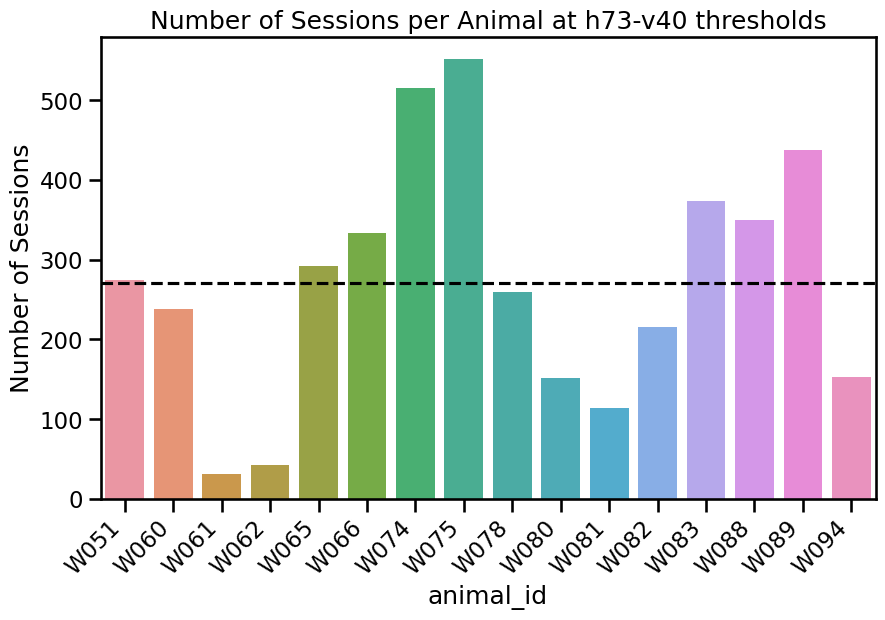

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x="animal_id", y="n_sessions", data=filtered_summary_stats, ax=ax)


_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

_ = ax.set(
    title="Number of Sessions per Animal at h73-v40 thresholds",
    ylabel="Number of Sessions",
)

ax.axhline(mean_sessions, color="black", linestyle="--")

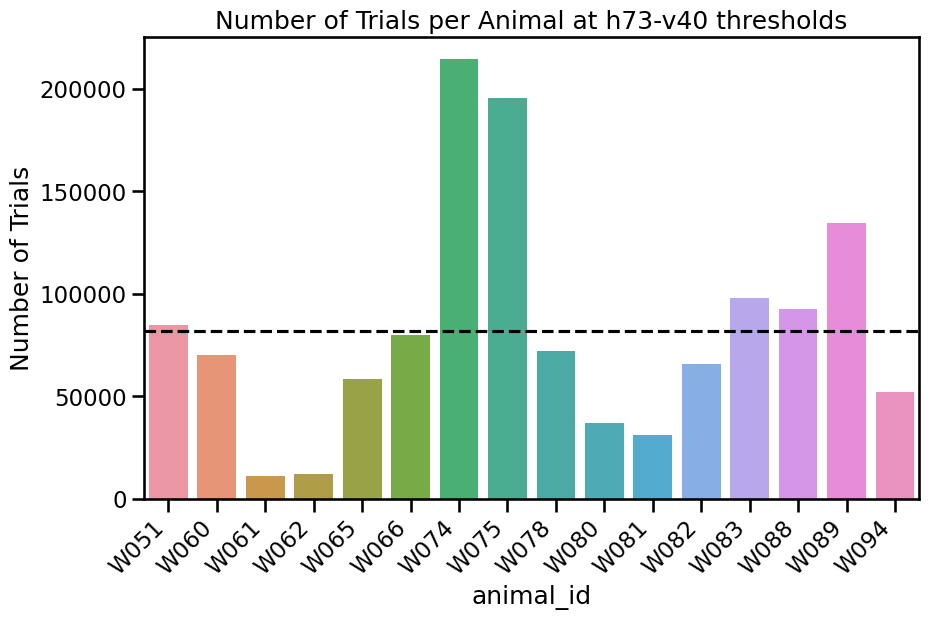

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x="animal_id", y="n_trials", data=filtered_summary_stats, ax=ax)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


_ = ax.set(
    title="Number of Trials per Animal at h73-v40 thresholds",
    ylabel="Number of Trials",
)

ax.axhline(mean_trials, color="black", linestyle="--")

## Threshold at hit 75%

In [ ]:
# Generate DataFrames for both hit and violation thresholds
hit_threshold = 0.75
hit_threshold_df = calculate_threshold_crossings(hit_means, "hit", 21, hit_threshold)
viol_threshold_df = calculate_threshold_crossings(viol_means, "violation", 14, 0.40)

# Merge the DataFrames on 'animal_id'
hit_viol_threshold_df = hit_threshold_df[["animal_id", "max_cross_sess"]].merge(
    viol_threshold_df[["animal_id", "max_cross_sess"]],
    on="animal_id",
    suffixes=("_hit", "_viol"),
)

# Rename the columns
hit_viol_threshold_df.rename(
    columns={
        "max_cross_sess_hit": "hit_threshold",
        "max_cross_sess_viol": "violation_threshold",
    },
    inplace=True,
)
hit_viol_threshold_df.loc[
    hit_viol_threshold_df.violation_threshold < hit_viol_threshold_df.hit_threshold,
    "violation_threshold",
] = None

hit_viol_threshold_df

,animal_id,hit_threshold,violation_threshold
0,W051,435.0,NaN
1,W060,254.0,NaN
2,W061,NaN,399.0
3,W062,NaN,463.0
4,W065,271.0,396.0
5,W066,358.0,488.0
6,W074,150.0,NaN
7,W075,136.0,NaN
8,W078,113.0,NaN
9,W080,308.0,425.0


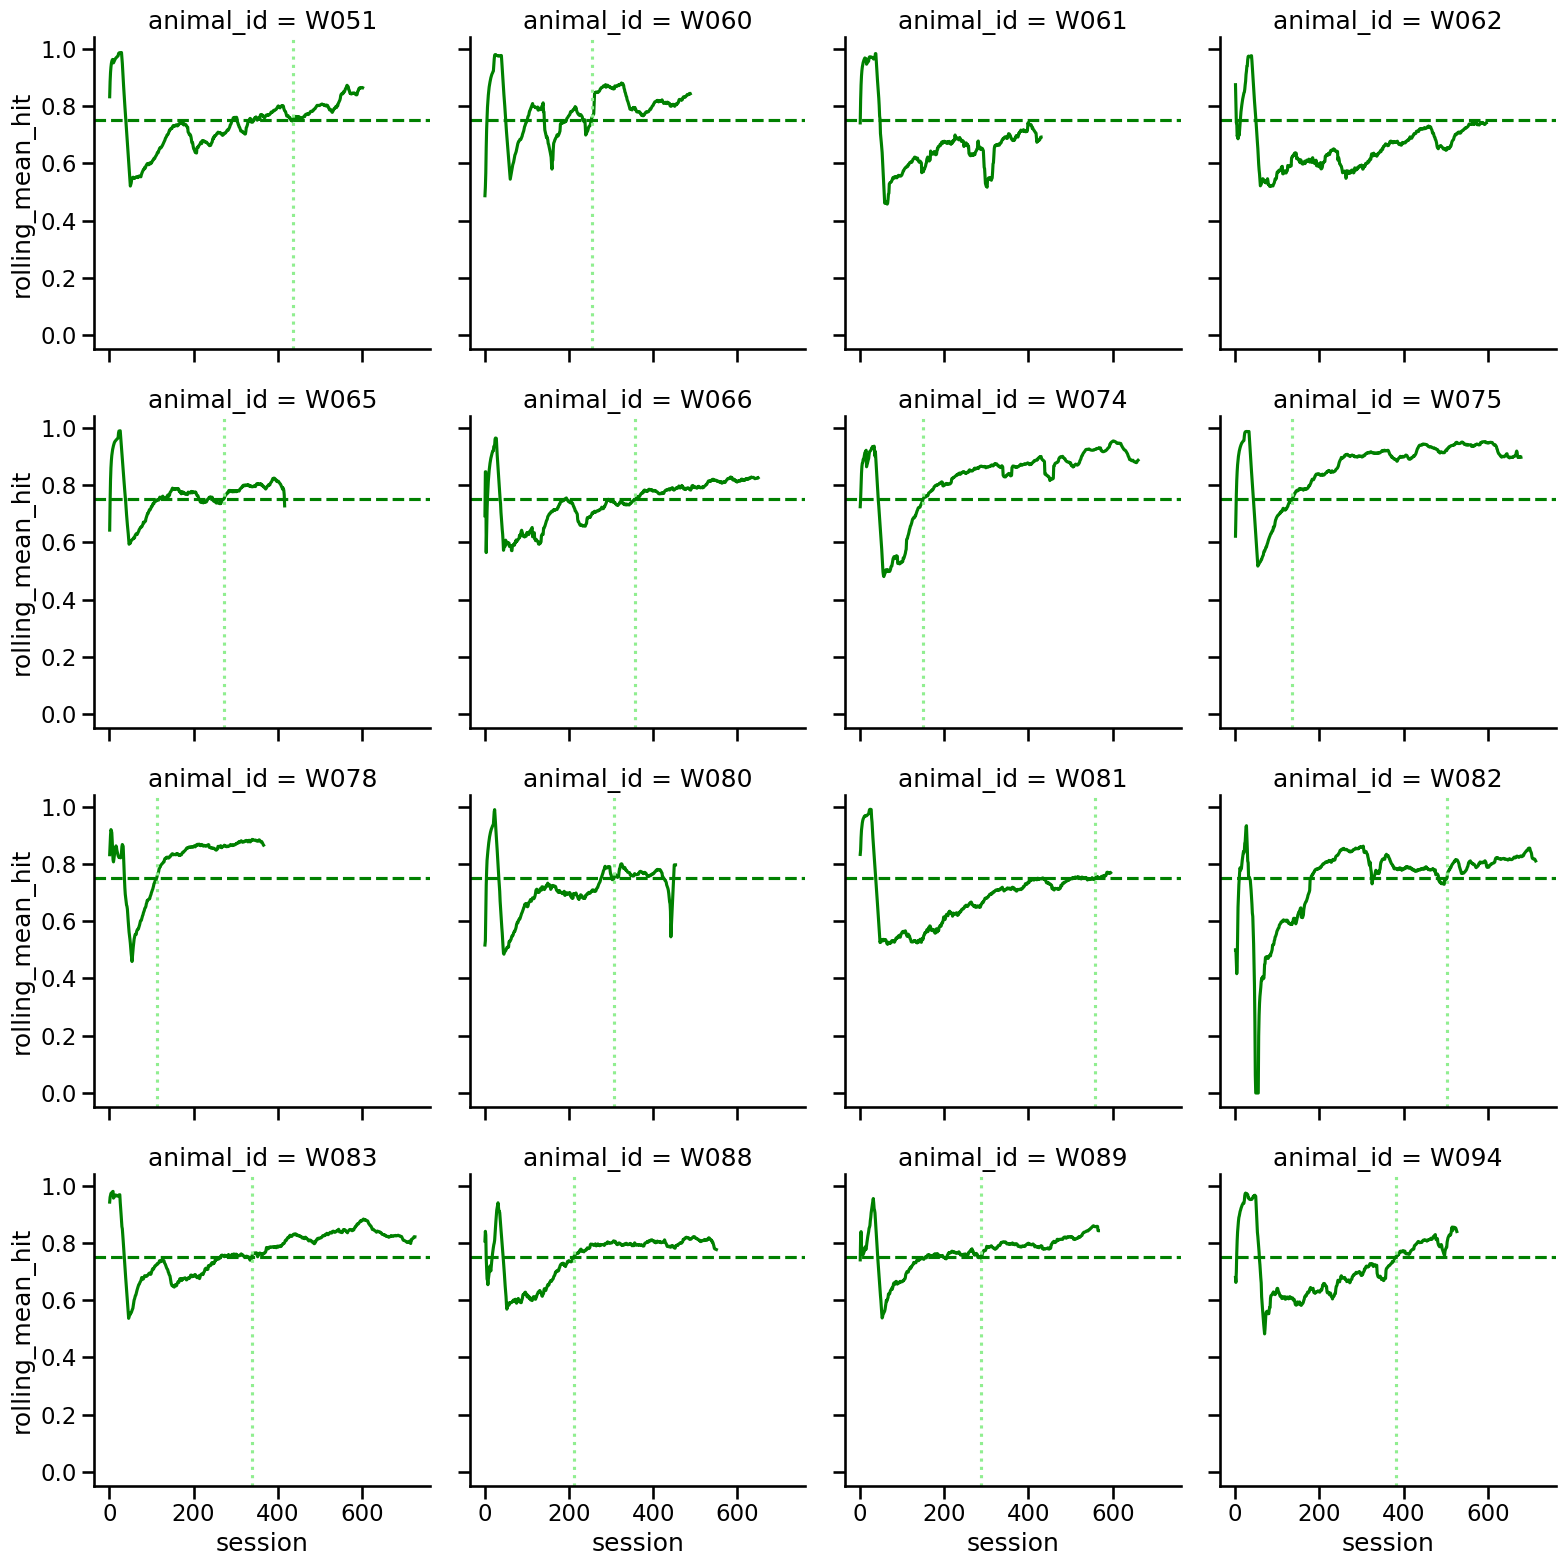

In [ ]:
# # Create the facet grid plot
window_size = hit_threshold_df["window_size"].unique()[0]
g = sns.FacetGrid(
    data=hit_means.query("window_size == @window_size"),
    col="animal_id",
    col_wrap=4,
    height=4,
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color="green")
g.map(plt.axhline, y=hit_threshold, color="green", linestyle="--")


for ii, ax in enumerate(g.axes.flat):
    ax.axvline(
        x=hit_viol_threshold_df["hit_threshold"][ii], color="lightgreen", linestyle=":"
    )

In [ ]:
hit_window = 21
hit_data = hit_viol_merge.query("window_size == @hit_window")[
    ["animal_id", "session", "rolling_mean_hit", "window_size"]
]
viol_window = 14
viol_data = hit_viol_merge.query("window_size == @viol_window")[
    ["animal_id", "session", "rolling_mean_violation", "window_size"]
]
plot_data = pd.merge(
    hit_data, viol_data, on=["animal_id", "session"], suffixes=("_hit", "_viol")
)

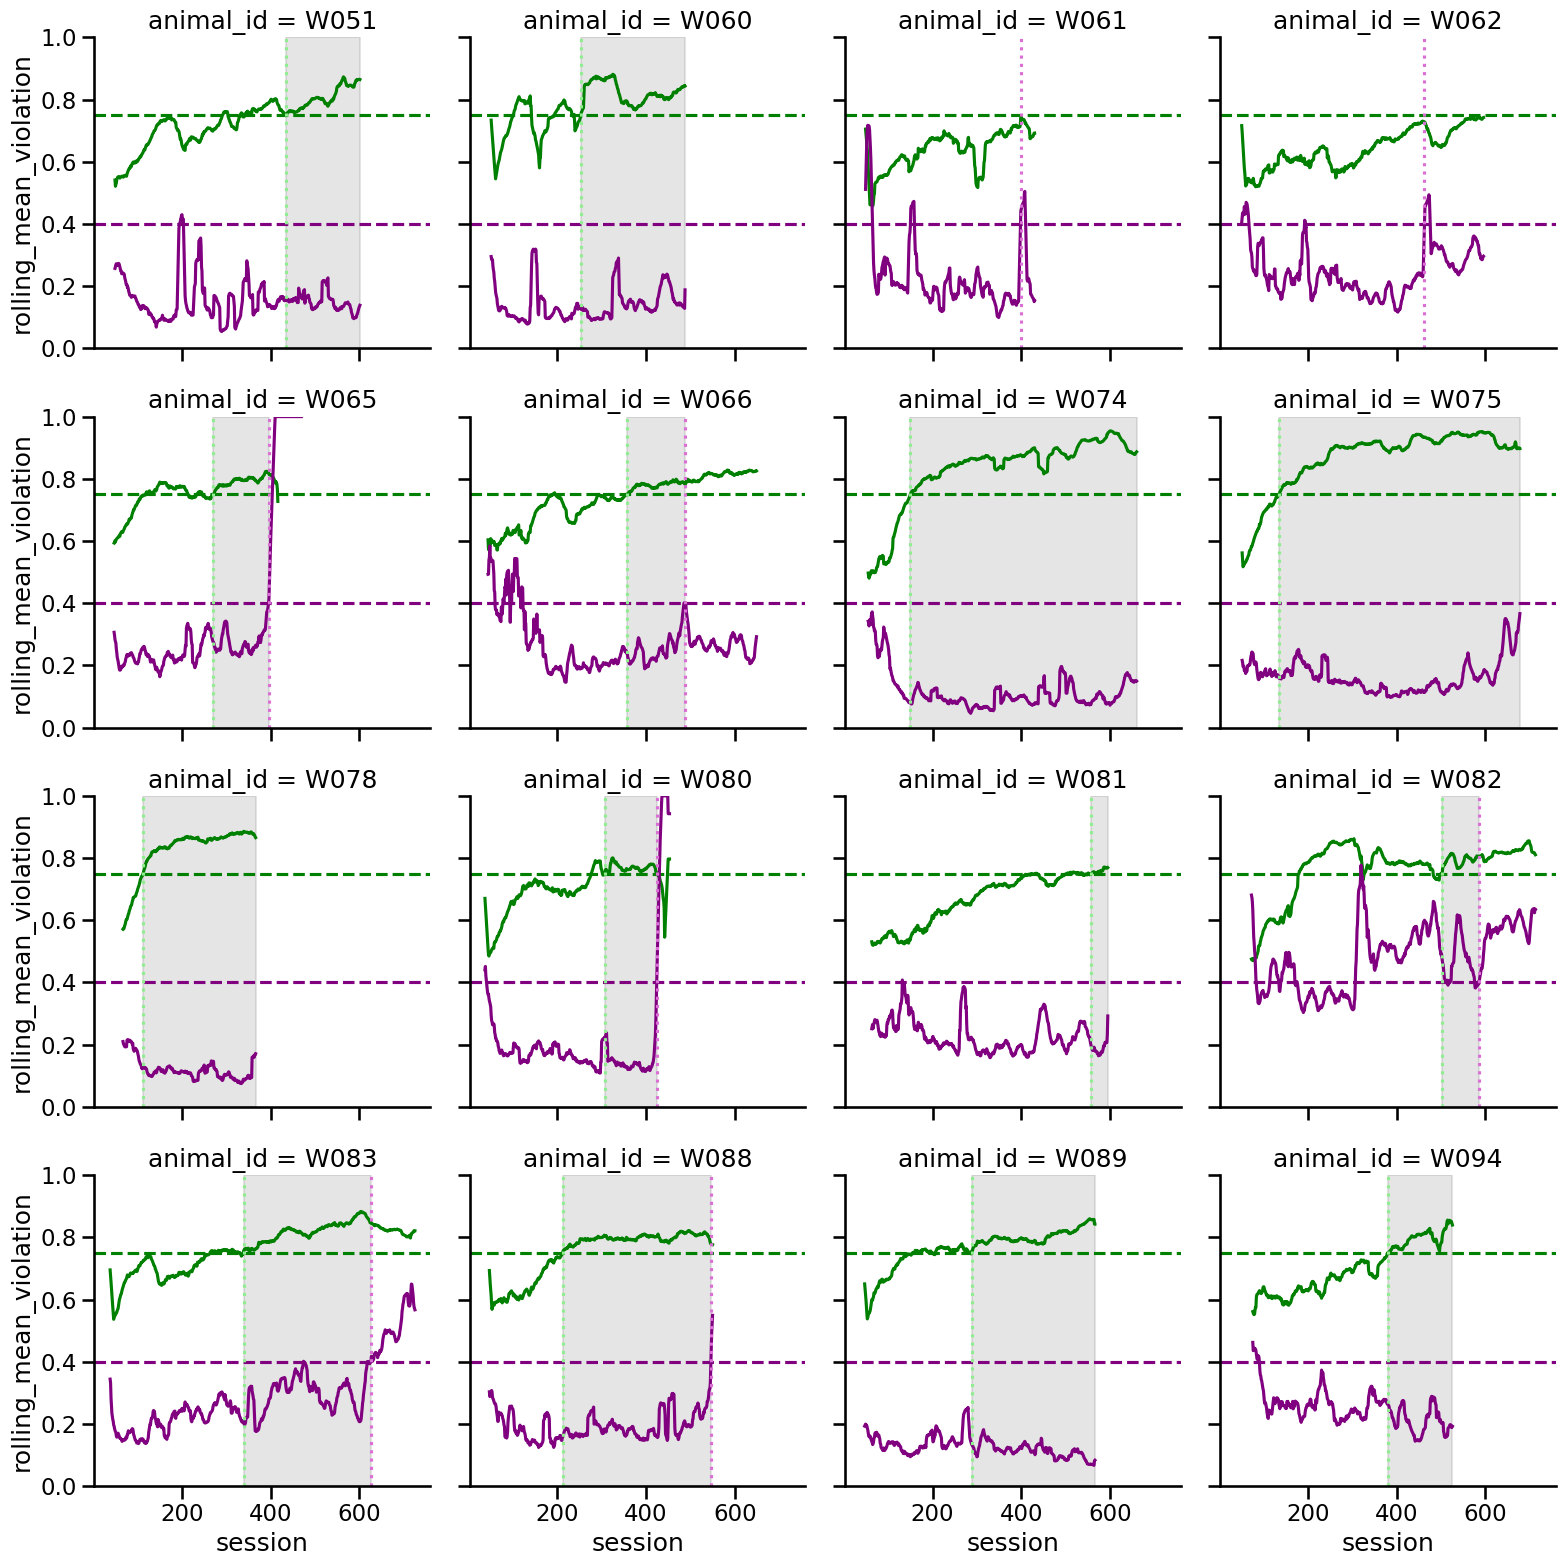

In [ ]:
# plot_data = hit_viol_merge.query("window_size == @hit_window")
plot_data = plot_data
g = sns.FacetGrid(
    data=plot_data,
    col="animal_id",
    col_wrap=4,
    height=4,
    ylim=(0, 1),
)
g.map(sns.lineplot, "session", "rolling_mean_hit", color="green")
g.map(plt.axhline, y=hit_threshold, color="green", linestyle="--")
g.map(sns.lineplot, "session", "rolling_mean_violation", color="purple")
g.map(plt.axhline, y=0.40, color="purple", linestyle="--")

# Assuming hit_viol_threshold_df and g are already defined
for ii, ax in enumerate(g.axes.flat):
    hit_threshold = hit_viol_threshold_df["hit_threshold"][ii]
    violation_threshold = hit_viol_threshold_df["violation_threshold"][ii]
    animal_id = hit_viol_threshold_df["animal_id"][ii]

    # Draw the first axvline for hit_threshold
    ax.axvline(x=hit_threshold, color="lightgreen", linestyle=":")

    if pd.notna(violation_threshold):
        ax.axvline(x=violation_threshold, color="orchid", linestyle=":")
        # Use fill_between to shade the area between the two axvlines
        ax.fill_betweenx(
            ax.get_ylim(), hit_threshold, violation_threshold, color="grey", alpha=0.2
        )
    else:
        # If violation_threshold is None, shade to the end of the line
        # Determine the maximum x-axis value from your data or use a predefined max value
        # print("evaluating!")
        max_x_value = plot_data.query(
            "animal_id == @animal_id"
        ).session.max()  # Or use a specific value based on your dataset
        ax.fill_betweenx(
            ax.get_ylim(), hit_threshold, max_x_value, color="grey", alpha=0.2
        )

In [ ]:
filtered_df = (
    df.query("training_stage > 3")
    .groupby("animal_id")
    .apply(filter_sessions)
    .reset_index(drop=True)
)

In [ ]:
filtered_summary_stats = (
    filtered_df.groupby("animal_id")
    .agg(n_trials=("hit", "count"), n_sessions=("session", "nunique"))
    .reset_index()
)

In [ ]:
filtered_summary_stats

,animal_id,n_trials,n_sessions
0,W051,54876,166
1,W060,68835,233
2,W065,26763,124
3,W066,32155,129
4,W074,213292,510
5,W075,192598,542
6,W078,70699,253
7,W080,28931,116
8,W081,12656,37
9,W082,22453,83


In [ ]:
mean_trials = filtered_summary_stats.n_trials.mean()
mean_sessions = filtered_summary_stats.n_sessions.mean()

filtered_summary_stats.loc[len(filtered_summary_stats)] = ["W061", 0, 0]
filtered_summary_stats.loc[len(filtered_summary_stats)] = ["W062", 0, 0]

In [ ]:
filtered_summary_stats.sort_values("animal_id", inplace=True)

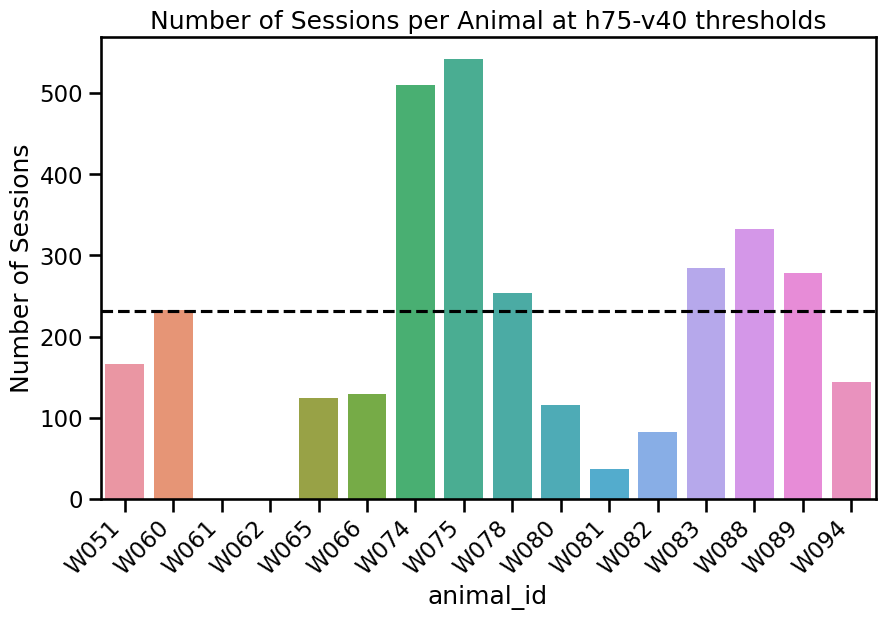

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x="animal_id", y="n_sessions", data=filtered_summary_stats, ax=ax)


_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

_ = ax.set(
    title="Number of Sessions per Animal at h75-v40 thresholds",
    ylabel="Number of Sessions",
)

ax.axhline(mean_sessions, color="k", linestyle="--")

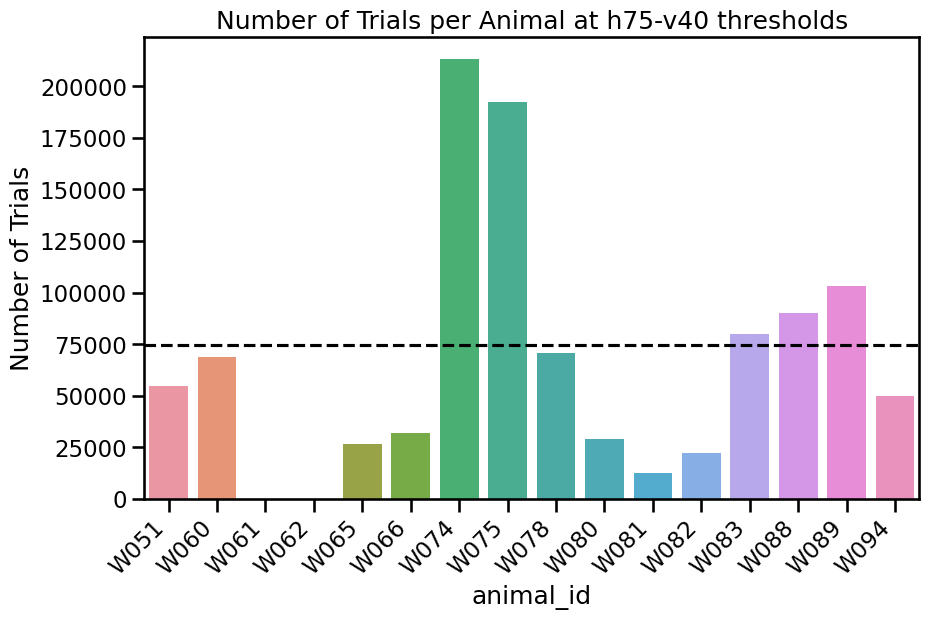

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x="animal_id", y="n_trials", data=filtered_summary_stats, ax=ax)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


_ = ax.set(
    title="Number of Trials per Animal at h75-v40 thresholds",
    ylabel="Number of Trials",
)

ax.axhline(mean_trials, color="k", linestyle="--")